# Homework (Week 3) -- Biometrics (20 points)

In this homework we train Biometrics Verification model and use some features to increase quality:
1) Train ECAPA-TDNN (10 points)
2) Any contrastive loss (10 points)

Link to download dataset: https://disk.yandex.ru/d/lyhtieYbxQOYqw

In [1]:
import os

import torchaudio
torchaudio.set_audio_backend('ffmpeg')

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as torch_data
import tqdm.notebook as tqdm

import dataset

from IPython.display import clear_output

%matplotlib inline

/tmp/ipykernel_44382/3297159001.py:4: UserWarning: torchaudio._backend.set_audio_backend has been deprecated. With dispatcher enabled, this function is no-op. You can remove the function call.
  torchaudio.set_audio_backend('ffmpeg')


In [2]:
# base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'
# public_key = 'https://disk.yandex.ru/d/lyhtieYbxQOYqw'
# final_url = base_url + urllib.parse.urlencode(dict(public_key=public_key))
# response = requests.get(final_url)
# download_url = response.json()['href']
# !wget -O voxceleb.tar.gz "{download_url}"
# !tar -xf voxceleb.tar.gz

### Some model train example

In [3]:
DEVICE = 'cuda' 
DATADIR = 'data'
FEATS = 80
LOADER_WORKERS = 12

In [4]:
transform = torchaudio.transforms.MFCC(n_mfcc=FEATS) 
transform_aug = nn.Sequential(
    torchaudio.transforms.MFCC(n_mfcc=FEATS),
    torchaudio.transforms.TimeMasking(time_mask_param=40),
    torchaudio.transforms.FrequencyMasking(freq_mask_param=7)
)

trainset = dataset.Dataset(os.path.join(DATADIR, 'voxceleb_train'), transform_aug)
testset = dataset.Dataset(os.path.join(DATADIR, 'voxceleb_test'), transform)
test_targets = pd.read_csv(os.path.join(DATADIR, 'target.csv')).values.tolist()

/home/kolya/speech_course/week_03_kws_bio/myenv/lib/python3.12/site-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(


### Models

In [5]:
class Model(nn.Module):
    def __init__(self, input_shape: int, output_shape: int, hidden: int, kernel: int = 7, sride: int = 2):
        super().__init__()
        self._emb = nn.Sequential(
            nn.Conv1d(input_shape, hidden, kernel, stride=sride),
            nn.ReLU(),
            nn.Conv1d(hidden, hidden, kernel, stride=sride),
            nn.ReLU(),
            nn.Conv1d(hidden, hidden, kernel, stride=sride),
            nn.AdaptiveMaxPool1d(1),
        )
        self._final = nn.Sequential(
            nn.Linear(hidden, output_shape),
            nn.LogSoftmax(dim=-1)
        )

    def forward(self, X) -> tuple[torch.Tensor, torch.Tensor]:
        emb = self._emb(X).squeeze(2)
        return self._final(emb), emb

### Metrics

Cosine similarity:
$CS(a, b) = \frac{<a, b>}{\|a\| \|b\|}$

In [6]:
def cosine_similarity(a, b):
    a = a.reshape(-1)
    b = b.reshape(-1)
    return np.dot(a, b) / np.linalg.norm(a) / np.linalg.norm(b)

Here is O(N log N) algorithm for find best_eer:
1) Sort prediction by probability
2) Going through items and recalculating far and frr

In [7]:
def best_eer(data):
    full = sorted(data, key=lambda x: (x[0], -x[1]))
    pos = len([item for item in full if item[1] == 1])
    neg = len(full) - pos
    cur_pos = pos
    cur_neg = 0
    best_eer = 1
    for _, label in full:
        if label == 1:
            cur_pos -= 1
        else:
            cur_neg += 1
        cur_eer = max((pos - cur_pos) / pos, (neg - cur_neg) / neg)
        best_eer = min(best_eer, cur_eer)
    return best_eer

### Train

In [8]:
def train_stage(model, opt, epoch = 0, scheduler=None, batch_size: int = 256):
    loader = torch_data.DataLoader(
        trainset,
        shuffle=True,
        batch_size=batch_size,
        collate_fn=dataset.collate_fn,
        num_workers=LOADER_WORKERS,
    )
    loss_sum = 0.0
    batches = 0
    for _, (X, Y, _) in enumerate(tqdm.tqdm(loader)):
        logits, _ = model.forward(X.to(DEVICE))
        loss = F.nll_loss(logits, Y.to(DEVICE))
        loss_sum += loss.item()
        batches += 1
        opt.zero_grad()
        loss.backward()
        opt.step()
    return loss_sum / batches

In [9]:
def calc_eval_score(model: nn.Module, batch_size: int = 256):
    loader = torch_data.DataLoader(
        testset,
        batch_size=batch_size,
        collate_fn=dataset.collate_fn,
        num_workers=LOADER_WORKERS,
    )
    items = {}
    target_scores = []
    with torch.no_grad():
        for X, _, pathes in tqdm.tqdm(loader):
            _, embds = model.forward(X.to(DEVICE))
            embds = embds.cpu().data.numpy().reshape(X.shape[0], -1)
            for embd, path in zip(embds, pathes):
                items[path] = embd
    for item1, item2, target in test_targets:
        target_scores.append((cosine_similarity(items[item1], items[item2]), target))
    return best_eer(target_scores)

In [10]:
def train(
    model: nn.Module,
    opt,
    name,
    scheduler = None,
    batch_size: int = 256,
    epochs: int = 13,
    train_fun = train_stage,
    train_kwargs = {},
):
    train_losses = []
    eval_scores = []
    for epoch in range(epochs):
        model.train()
        train_losses.append(train_fun(model, opt, batch_size=batch_size))
        model.eval()
        eval_scores.append(calc_eval_score(model, batch_size=batch_size))
        clear_output()
        
        if scheduler is not None: scheduler.step()
                
        fig, axis = plt.subplots(1, 2, figsize=(15, 7))
        axis[0].plot(np.arange(1, epoch + 2), train_losses, label=f'train {name} loss')
        axis[1].plot(np.arange(1, epoch + 2), eval_scores, label='eval')
        axis[0].set(xlabel='epoch', ylabel=f'{name} Loss')
        axis[1].set(xlabel='epoch', ylabel='EER')
        fig.legend()
        plt.show()
        print(f'Epoch {epoch + 1}. Train loss {train_losses[-1]}. Eval score {eval_scores[-1]}')

In [11]:
# model = Model(FEATS, trainset.speakers(), 128).to(DEVICE)
# opt = optim.Adam(model.parameters())
# train(model, opt)

### ECAPA TDNN (10 points)

Paper: https://arxiv.org/pdf/2005.07143.pdf

Papers for ECAPA parts:
- SE-Blocks - https://arxiv.org/pdf/1709.01507.pdf
- Res2Net - https://arxiv.org/pdf/1904.01169.pdf
- Attentive Stats Pooling - https://arxiv.org/pdf/1803.10963.pdf
- AAM Softmax - https://arxiv.org/pdf/1906.07317.pdf

Also you can optionally add other settings for paper:
- SpecAug
- Weight decay for optimizer
- LR scheduler

In [12]:
get_padding = lambda dilation, ker_size: dilation * (ker_size - 1) // 2

In [13]:
class SEBlock(nn.Module):
    def __init__(self, input_shape: int, reduction: int = 16):
        super().__init__()
        self.fc_1 = nn.Linear(input_shape, input_shape // reduction, bias=False)
        self.fc_2 = nn.Linear(input_shape // reduction, input_shape, bias=False)
        self.global_avg_pool = nn.AdaptiveAvgPool1d(1)

    def __call__(self, X):
        batch, C, L = X.size()
        res = self.global_avg_pool(X).view(batch, C)
        res = self.fc_1(res)
        res = torch.sigmoid(self.fc_2(F.relu(res)))
        return X * res.view(batch, C, 1)


In [ ]:
class Res2Net(nn.Module):
    def __init__(self, hidden: int, dilation: int, scale_res2net: int):
        super().__init__()
        assert hidden % scale_res2net == 0
        self.s = scale_res2net
        self.chunk = hidden // scale_res2net

        self.convs = nn.ModuleList([
            nn.Conv1d(self.chunk, self.chunk, 
                      kernel_size=3, padding=dilation, dilation=dilation, bias=False)
            for _ in range(scale_res2net - 1)
        ])
        
        self.relu = nn.ReLU(inplace=True)
        self.conv1d = nn.Conv1d(hidden, hidden, kernel_size=1, bias=False)

    def __call__(self, X):
        out = []
        split_parts = torch.split(X, self.chunk, dim=1) 
        out.append(split_parts[0])
        
        for i in range(1, self.s):
            if i == 1:
                local = split_parts[i]
            else:
                local = split_parts[i] + out[i - 1]
            out.append(self.relu(self.convs[i - 1](local)))
            
        out = self.relu(self.conv1d(torch.cat(out, dim=1) ))
        return out + X

In [15]:
class AttentiveStatsPooling(nn.Module):
    def __init__(self, input_shape: int, hidden: int):
        super().__init__()
        self.conv1 = nn.Conv1d(input_shape, hidden, kernel_size=1)
        self.relu = nn.ReLU()
        self.conv2 = nn.Conv1d(hidden, 1, kernel_size=1)

    def forward(self, X):
        scores = self.conv2(self.relu(self.conv1(X)))
        weights = torch.softmax(scores, dim=2)
        weighted_mean = torch.sum(weights * X, dim=2)
        ex2 = torch.sum(weights * X**2, dim=2) 
        variance = ex2 - weighted_mean**2
        min_val = torch.full_like(variance, 1e-6)
        variance = torch.maximum(variance, min_val)
        weighted_std = torch.sqrt(variance)
        return torch.cat([weighted_mean, weighted_std], dim=1)


In [16]:
class AAMSoftmax(nn.Module):
    def __init__(self, input_shape, n_class, margin=0.2, scale=30):
        super().__init__()
        self.m = margin
        self.s = scale
        self.weight = nn.Parameter(torch.randn(n_class, input_shape))
        self.weight.data = F.normalize(self.weight.data, p=2, dim=1)
        
    def forward(self, X):
        x_norm = F.normalize(X, p=2, dim=1)
        w_norm = F.normalize(self.weight, p=2, dim=1)
        cos = torch.matmul(x_norm, w_norm.t())
                
        tetas = torch.acos(cos)
        exp_no_margin = torch.exp(self.s * cos)
        num = torch.exp(self.s * torch.cos(tetas + self.m))
        denom = num + torch.sum(exp_no_margin, dim=1, keepdim=True) - exp_no_margin
        return torch.log(torch.div(num, denom))

In [17]:
class EcapaBlock(nn.Module):
    def __init__(self, hidden: int, dilation: int, scale_res2net: int, n_class: int, embedding_dim: int, in_channels = FEATS):
        super().__init__()
        self.out_channels = 1536
        kernel_start = 5
        
        self.start_layer = nn.Sequential(
            nn.Conv1d(in_channels=in_channels, out_channels=hidden,
                      kernel_size=kernel_start, dilation=dilation,
                      padding=get_padding(dilation, kernel_start), bias=False),
            nn.ReLU(),
            nn.BatchNorm1d(hidden)
        )
        
        self.blocks = nn.ModuleList([
            nn.Sequential(
                Res2Net(hidden, dilation=d, scale_res2net=scale_res2net),
                SEBlock(hidden)
            ) for d in [2,3,4]
        ])
        
        self.processing = nn.Sequential(
            nn.Conv1d(hidden * 3, self.out_channels, kernel_size=1, bias=False),
            nn.BatchNorm1d(self.out_channels),
            nn.ReLU()
        )
        
        self.final_block = nn.Sequential(
            AttentiveStatsPooling(input_shape=self.out_channels, hidden=self.out_channels),
            nn.BatchNorm1d(self.out_channels * 2),
            nn.Linear(self.out_channels * 2, embedding_dim, bias=False),
            nn.BatchNorm1d(embedding_dim)
        )
        
        self.aam = AAMSoftmax(input_shape=embedding_dim, n_class=n_class)

    def __call__(self, X):
        out = self.start_layer(X)
        cat_out = torch.cat([self.blocks[0](out), self.blocks[1](out), self.blocks[2](out)], dim=1)
        proc = self.processing(cat_out)
        pooled = self.final_block(proc)
        logits = self.aam(pooled)
        return logits, pooled


In [18]:
class EcapaTDNN(nn.Module):
    def __init__(self, input_shape: int, n_class: int, embedding_dim: int):
        super().__init__()
        self.ecapa_block = EcapaBlock(hidden=256, dilation=1, scale_res2net=8, n_class=n_class, embedding_dim=embedding_dim)

    def forward(self, X):
        logits, emb = self.ecapa_block(X)
        return logits, emb

Train ECAPA model, at this point you can archive stable score (for several consecutive epochs) near 0.08 EER.

You can train ECAPA with hidden size 256 to increase speed

In [ ]:
from torch.optim import AdamW

model = EcapaTDNN(FEATS, trainset.speakers(), 128).to(DEVICE)
opt = AdamW(model.parameters(), lr=2e-3, weight_decay=1e-6)
scheduler = torch.optim.lr_scheduler.StepLR(opt, step_size=6, gamma=0.65)
train(model, opt, 'CE', scheduler, batch_size=128)

# Epoch 15. Train loss 0.45230512984518734. Eval score 0.08188696039163329

![alt text](output_1.png)

In [ ]:
torch.save(model, 'model.pt')

### Contrastive losses (10 points)

You can use anyone constrative loss.
Good article with contrastive losses https://lilianweng.github.io/posts/2021-05-31-contrastive/

Base losses:
- contrastive
- triplet -- it gives a better quality usually
- lifted structured loss -- better batch data utilization

The main problem with contrastive loss is the positive pairs sampler.
This is because a large number of classes provided only once per batch
in case of large number of classes in the dataset.

In [ ]:
from collections import defaultdict
import numpy as np
import torch
import matplotlib.pyplot as plt

class PositivePairsSampler(torch.utils.data.Sampler):
    def __init__(self, speakers: list[int], batch_size: int, flag=False):
        self.speakers = speakers
        self.batch_size = batch_size
        self.speakers_dict = defaultdict(list)
        self.min_mes = 5
        
        for idx, spk_id in enumerate(speakers):
            self.speakers_dict[spk_id].append(idx)
        
        self.total = len(self.speakers)
        self.batches = []
        
        self.small_range = (0, 35)
        self.normal_36_42 = (36, 42)
        self.normal_43_48 = (43, 48)
        self.normal_49_52 = (49, 52)
        self.normal_53_59 = (53, 59)
        self.uniform = (60, 60)  

        self.small = []
        self.gr_36_42 = []
        self.gr_43_48 = []
        self.gr_49_52 = []
        self.gr_53_59 = []
        self.uniform = []

        for spk, idxs in self.speakers_dict.items():
            c = len(idxs)
            if c <= self.small_range[1]:
                self.small.append(spk) 
            elif self.normal_36_42[0] <= c <= self.normal_36_42[1]:
                self.gr_36_42.append(spk)
            elif self.normal_43_48[0] <= c <= self.normal_43_48[1]:
                self.gr_43_48.append(spk)
            elif self.normal_49_52[0] <= c <= self.normal_49_52[1]:
                self.gr_49_52.append(spk)
            elif self.normal_53_59[0] <= c <= self.normal_53_59[1]:
                self.gr_53_59.append(spk)
            else:
                self.uniform.append(spk)

        if flag:
            self._separate_batches()
            
    def _separate_batches(self):
        self._batches_for_group(self.small)
        self._batches_for_group(self.gr_36_42)
        self._batches_for_group(self.gr_43_48)
        self._batches_for_group(self.gr_49_52)
        self._batches_for_group(self.gr_53_59)
        self._batches_for_group(self.uniform)
        
    def _batches_for_group(self, group_spk: list):
        group_total = sum(len(self.speakers_dict[spk]) for spk in group_spk)
        num_batches = group_total // self.batch_size

        for _ in range(num_batches):
            cur_batch = []
            cur_batch_size = 0
            while cur_batch_size < self.batch_size and group_spk:
                need = self.batch_size - cur_batch_size
                taken = self._sample_from_group(group_spk, need, cur_batch)
                cur_batch_size += taken

            if len(cur_batch) > 0:
                self.batches.append(cur_batch)

    def _balanced_batches(self):
        total_messages = sum(len(idxs) for idxs in self.speakers_dict.values())
        num_batches = total_messages // self.batch_size

        for _ in range(num_batches):
            total_small = sum(len(self.speakers_dict[spk]) for spk in self.small)
            total_36_42 = sum(len(self.speakers_dict[spk]) for spk in self.gr_36_42)
            total_43_48 = sum(len(self.speakers_dict[spk]) for spk in self.gr_43_48)
            total_49_52 = sum(len(self.speakers_dict[spk]) for spk in self.gr_49_52)
            total_53_59 = sum(len(self.speakers_dict[spk]) for spk in self.gr_53_59)
            total_uniform = sum(len(self.speakers_dict[spk]) for spk in self.uniform)
            all = total_small + total_36_42 + total_43_48 + total_49_52 + total_53_59 + total_uniform

            r_small = total_small / all 
            r_36_42 = total_36_42 / all 
            r_43_48 = total_43_48 / all 
            r_49_52 = total_49_52 / all 
            r_53_59 = total_53_59 / all 

            count_small = int(self.batch_size * r_small)
            count_36_42 = int(self.batch_size * r_36_42)
            count_43_48 = int(self.batch_size * r_43_48)
            count_49_52 = int(self.batch_size * r_49_52)
            count_53_59 = int(self.batch_size * r_53_59)

            cur_batch = []
            self._sample_from_group(self.small, count_small, cur_batch)
            self._sample_from_group(self.gr_36_42, count_36_42, cur_batch)
            self._sample_from_group(self.gr_43_48, count_43_48, cur_batch)
            self._sample_from_group(self.gr_49_52, count_49_52, cur_batch)
            self._sample_from_group(self.gr_53_59, count_53_59, cur_batch)
            remaind = self.batch_size - len(cur_batch)
            self._sample_from_group(self.uniform, remaind, cur_batch)
            
            if cur_batch:   
                self.batches.append(cur_batch)


    def _sample_from_group(self, group_spk: list, needed: int, cur_batch: list) -> int:
        taken = 0
        if needed == 0:
            return 0
        
        while taken < needed and group_spk:
            weights = np.array([len(self.speakers_dict[spk]) for spk in group_spk], dtype=float)
            weights /= weights.sum()
            
            picked = np.random.choice(group_spk, p=weights)
            can_take = len(self.speakers_dict[picked])
            num_take = min(self.min_mes, can_take, needed - taken)
            if num_take == 0:
                group_spk.remove(picked)
                continue
            
            indices = self.speakers_dict[picked][:num_take]
            self.speakers_dict[picked] = self.speakers_dict[picked][num_take:]
            
            cur_batch.extend(indices)
            taken += num_take
            
            if len(self.speakers_dict[picked]) == 0:
                group_spk.remove(picked)
        
        return taken


    def plot_distribution(self):
        counts = [len(idxs) for idxs in self.speakers_dict.values()]
        print(f"Спикеров с < 60 сообщениями: {sum(1 for c in counts if c < 60)}")
        plt.hist(counts, bins=30, edgecolor='black', color='skyblue')
        plt.xlabel("Количество сообщений")
        plt.ylabel("Количество участников")
        plt.grid(True, linestyle='--', alpha=0.6)
        plt.show()

    def __len__(self):
        return len(self.batches)

    def __iter__(self):
        for b in self.batches:
            yield b


In [22]:
import random

def contrastive_train_stage(model, opt, batch_size: int = 256):
    loader = torch_data.DataLoader(
        trainset,
        collate_fn=dataset.collate_fn,
        num_workers=LOADER_WORKERS,
        batch_sampler=PositivePairsSampler(trainset._speakers, batch_size, True)
    )
    
    trip_loss_get = nn.TripletMarginLoss(margin = 0.4)
    total_loss = 0.0
    batches = 0
    skipped = 0
    count_pos = 1
    count_neg = 1
    
    for cur_batch in tqdm.tqdm(loader):
        audio, target, _ = cur_batch
        audio = audio.to(DEVICE)
        target = target.to(DEVICE)
        
        logits, embeddings = model(audio)
        embeddings = F.normalize(embeddings, p=2, dim=1) 
        cls_loss = F.nll_loss(logits, target)
        
        cur_objects, pos, neg = [], [], []
        
        for i in range(len(target)):
            others = torch.where(target != target[i])[0]
            dists_neg = torch.cdist(embeddings[i].unsqueeze(0), embeddings[others], p=2).squeeze()
            k = max(1, int(len(others) * 0.4))
            _, nearest_neg = torch.topk(dists_neg, k=k, largest=False)
            nearest_neg = nearest_neg.tolist()  
            neg_cand = others[random.sample(nearest_neg, count_neg)]
            
            indices = torch.arange(len(target), device=target.device)
            sames = indices[(target == target[i]) & (indices != i)]
            
            if len(sames) == 0:
                skipped += 1
                continue
            
            dists_pos = torch.cdist(embeddings[i].unsqueeze(0), embeddings[sames], p=2).squeeze()
            k = max(1, int(len(sames) * 0.4))
            _, most_far_pos = torch.topk(dists_pos, k=k, largest=True)
            
            most_far_pos = torch.atleast_1d(most_far_pos).tolist()
            pos_candidates = sames[random.sample(most_far_pos, min(len(most_far_pos), count_pos))]
                
            for pos_idx in pos_candidates:
                for neg_idx in neg_cand:
                    cur_objects.append(embeddings[i])
                    pos.append(embeddings[pos_idx])
                    neg.append(embeddings[neg_idx])

            
        cur_objects = torch.stack(cur_objects)
        pos = torch.stack(pos)
        neg = torch.stack(neg)
        
        trip_loss = trip_loss_get(cur_objects, pos, neg)
        loss = 0.6 * cls_loss + trip_loss
        
        opt.zero_grad()
        loss.backward()
        opt.step()
        
        total_loss += loss.item()
        batches += 1
    
    print(trip_loss)  
    print(skipped)
    return total_loss / batches


Train model with contrastive loss here. At this point you can archive EER near 0.06-0.07 (it should be at least on 0.005 to 0.01 better than before)

Спикеров с < 60 сообщениями: 376


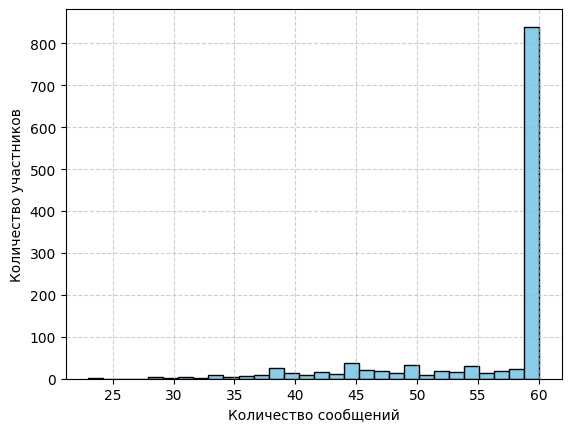

In [ ]:
sampler = PositivePairsSampler(trainset._speakers, batch_size=175)
sampler.plot_distribution()

In [ ]:
from torch.optim import AdamW

model = torch.load('model.pt', weights_only=False).to(DEVICE)
opt = AdamW(model.parameters(), lr=1e-4, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.StepLR(opt, step_size=6, gamma=0.65)
train(model, opt, "ctf", scheduler, batch_size=175, train_fun=contrastive_train_stage)

# Epoch 13. Train loss 1.0387515952060749. Eval score 0.07519888874857937

![alt text](output_2.png)